# Analyzing Susceptibility Scores
Given a CSV with the columns:

```q_id,	query_form,	entity,	contexts,	susceptibility_score```

Analyze the results for patterns and correlations

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import warnings

# warnings.filterwarnings("ignore")
from ast import literal_eval
import json
import os
from pathlib import Path
import sys
import math
import random
from itertools import product
from tqdm import tqdm
import yaml

import pandas as pd
import seaborn as sns

# from transformers import GPTNeoXForCausalLM, AutoTokenizer
# import torch
from typing import List, Dict
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import wandb

import statsmodels.api as sm

In [3]:
# IMPORTANT: Run as if from project root so that imports work.
pardir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(pardir)
os.getcwd()

'/home/kevin/code/rycolab/measureLM'

In [4]:
from analysis_helpers import (
    add_val_df_to_wandb,
    construct_df_given_query_id,
    load_val_df_from_wandb,
    permutation_test,
    percent_ents_passing_pscore_permutation_test,
)
from preprocessing.datasets import YagoECQ
from preprocessing.utils import extract_name_from_yago_uri
from utils import load_artifact_from_wandb, construct_paths_and_dataset_kwargs

### Preamble

In [5]:
# sns.color_palette("colorblind")
# print(sns.color_palette("colorblind").as_hex())

Text(0.5, 1.0, 'ABC123 vs $\\mathrm{ABC123}^{123}$')

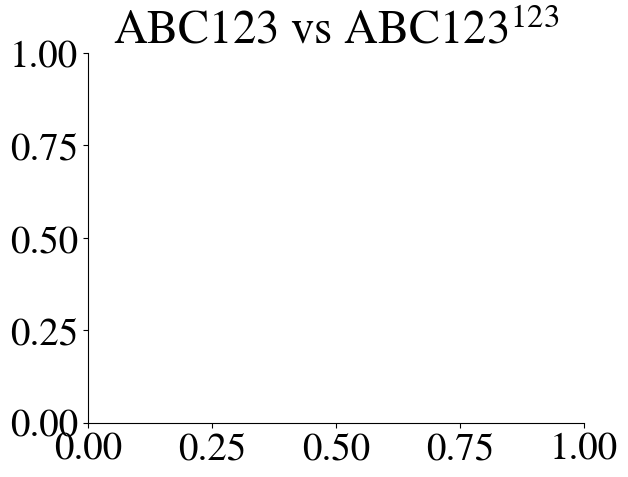

In [6]:
from mpl_styles import *

matplotlib.pyplot.title(r"ABC123 vs $\mathrm{ABC123}^{123}$")

In [7]:
##############
# Parameters #
##############
CONFIG_PATH = "analysis/config-s8.yml"
with open(CONFIG_PATH) as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# Data parameters
DATASET_NAME = config["DATASET_NAME"]
RAW_DATA_PATH = config["RAW_DATA_PATH"]
SEED = config["SEED"]
MODEL_ID = config["MODEL_ID"]
LOAD_IN_8BIT = config["LOAD_IN_8BIT"]
MAX_CONTEXTS = config["MAX_CONTEXTS"]
MAX_ENTITIES = config["MAX_ENTITIES"]
CAP_PER_TYPE = config["CAP_PER_TYPE"]
ABLATE_OUT_RELEVANT_CONTEXTS = config["ABLATE_OUT_RELEVANT_CONTEXTS"]
UNIFORM_CONTEXTS = config["UNIFORM_CONTEXTS"]
DEDUPLICATE_ENTITIES = config["DEDUPLICATE_ENTITIES"]
ENTITY_SELECTION_FUNC_NAME = config["ENTITY_SELECTION_FUNC_NAME"]
ENTITY_TYPES = config["ENTITY_TYPES"]
QUERY_TYPES = config["QUERY_TYPES"]
ANSWER_MAP = config["ANSWER_MAP"]

In [8]:
# wandb stuff
PROJECT_NAME = "context-vs-bias"
GROUP_NAME = None
TAGS = ["yago", "analysis"]
LOG_DATASETS = True

os.environ["WANDB_NOTEBOOK_NAME"] = os.path.join("analysis", "analysis-yago.ipynb")

params_to_log = {k: v for k, v in locals().items() if k.isupper()}

run = wandb.init(
    project=PROJECT_NAME,
    group=GROUP_NAME,
    config=params_to_log,
    tags=TAGS,
    # mode="disabled",
)
print(dict(wandb.config))

wandb: Currently logged in as: kdu (ethz-rycolab). Use `wandb login --relogin` to force relogin


{'ENTITY_COLOR': [0.00392156862745098, 0.45098039215686275, 0.6980392156862745], 'CONTEXT_COLOR': [0.8705882352941177, 0.5607843137254902, 0.0196078431372549], 'OPEN_COLOR': [0.00784313725490196, 0.6196078431372549, 0.45098039215686275], 'CLOSED_COLOR': [0.8352941176470589, 0.3686274509803922, 0.0], 'LINE_COLOR': [0.5803921568627451, 0.5803921568627451, 0.5803921568627451], 'REAL_COLOR': [0.792156862745098, 0.5686274509803921, 0.3803921568627451], 'FAKE_COLOR': [0.5803921568627451, 0.5803921568627451, 0.5803921568627451], 'DIFF_COLOR': [0.984313725490196, 0.6862745098039216, 0.8941176470588236], 'CONFIG_PATH': 'analysis/config-s8.yml', 'DATASET_NAME': 'YagoECQ', 'RAW_DATA_PATH': 'data/YagoECQ/yago_qec.json', 'SEED': 8, 'MODEL_ID': 'EleutherAI/pythia-6.9b-deduped', 'LOAD_IN_8BIT': True, 'MAX_CONTEXTS': 500, 'MAX_ENTITIES': 100, 'CAP_PER_TYPE': False, 'ABLATE_OUT_RELEVANT_CONTEXTS': False, 'UNIFORM_CONTEXTS': True, 'DEDUPLICATE_ENTITIES': True, 'ENTITY_SELECTION_FUNC_NAME': 'top_entity_u

In [9]:
# Downloads yago_qec.json from wandb (if not already cached there)
artifact, files = load_artifact_from_wandb(
    f"{DATASET_NAME}-yago_qec", save_dir=Path(RAW_DATA_PATH).parent
)
artifact.name

wandb:   1 of 1 files downloaded.  


'YagoECQ-yago_qec:latest'

In [10]:
with open(RAW_DATA_PATH) as f:
    yago_qec = json.load(f)

In [11]:
query_ids = list(yago_qec.keys())
for qid, v in list(yago_qec.items())[:10]:
    print(qid, len(v["entities"]), len(set(v["entities"])))

http://schema.org/about 954 947
http://schema.org/actor 1000 991
http://schema.org/address 1000 997
http://schema.org/administrates 998 798
http://schema.org/affiliation 994 962
http://schema.org/alumniOf 1000 999
http://schema.org/author 1000 997
http://schema.org/award 666 663
http://schema.org/birthDate 1000 999
http://schema.org/birthPlace 1000 1000


In [12]:
# Analysis dir
analysis_dir = os.path.join("analysis", DATASET_NAME, MODEL_ID)
os.makedirs(analysis_dir, exist_ok=True)
print(f"Analysis dir: {analysis_dir}")

Analysis dir: analysis/YagoECQ/EleutherAI/pythia-6.9b-deduped


In [13]:
# Set random seeds
# torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### Load Data

In [14]:
# qid_to_artifact_path = {
#     query_id: add_val_df_to_wandb(
#         yago_qec=yago_qec,
#         DATASET_NAME=DATASET_NAME,
#         RAW_DATA_PATH=RAW_DATA_PATH,
#         SEED=SEED,
#         MODEL_ID=MODEL_ID,
#         LOAD_IN_8BIT=LOAD_IN_8BIT,
#         QUERY_ID=query_id,
#         MAX_CONTEXTS=MAX_CONTEXTS,
#         MAX_ENTITIES=MAX_ENTITIES,
#         CAP_PER_TYPE=CAP_PER_TYPE,
#         UNIFORM_CONTEXTS=UNIFORM_CONTEXTS,
#         DEDUPLICATE_ENTITIES=DEDUPLICATE_ENTITIES,
#         ENTITY_SELECTION_FUNC_NAME=ENTITY_SELECTION_FUNC_NAME,
#         ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
#         ENTITY_TYPES=ENTITY_TYPES,
#         QUERY_TYPES=QUERY_TYPES,
#         ANSWER_MAP=ANSWER_MAP,
#         verbose=False,
#         overwrite_df=True,
#     )
#     # query_id: construct_df_given_query_id(query_id, convert_cols=["entity"], verbose=False)
#     for query_id in tqdm(query_ids)
# }

In [15]:
query_ids = list(
    set(query_ids).difference(
        [
            # "http://yago-knowledge.org/resource/studentsCount",
            # "http://schema.org/numberOfPages",
            "http://yago-knowledge.org/resource/distanceFromEarth",
            # "http://schema.org/numberOfEmployees",
            # "http://schema.org/numberOfEpisodes",
            # "http://schema.org/numberOfSeasons",
            # "http://schema.org/humanDevelopmentIndex",
            "http://schema.org/duns",
            # "http://schema.org/duration",
            "http://schema.org/unemploymentRate",
            "http://yago-knowledge.org/resource/radialVelocity",
            # "http://schema.org/populationNumber",
            "http://yago-knowledge.org/resource/luminosity",
            "http://yago-knowledge.org/resource/parallax",
            "http://yago-knowledge.org/resource/length",
            "http://schema.org/elevation",
            # "http://yago-knowledge.org/resource/sportNumber",
            "http://yago-knowledge.org/resource/mass",
        ]
        # [
        #     "http://yago-knowledge.org/resource/studentsCount",
        #     "http://schema.org/numberOfPages",
        #     "http://yago-knowledge.org/resource/distanceFromEarth",
        #     "http://schema.org/numberOfEmployees",
        #     "http://schema.org/numberOfEpisodes",
        #     "http://schema.org/numberOfSeasons",
        #     "http://schema.org/humanDevelopmentIndex",
        #     "http://schema.org/duns",
        #     "http://schema.org/duration",
        #     "http://schema.org/unemploymentRate",
        #     "http://yago-knowledge.org/resource/radialVelocity",
        #     "http://schema.org/populationNumber",
        #     "http://yago-knowledge.org/resource/luminosity",
        #     "http://yago-knowledge.org/resource/parallax",
        #     "http://yago-knowledge.org/resource/length",
        #     "http://schema.org/elevation",
        #     "http://yago-knowledge.org/resource/sportNumber",
        #     "http://yago-knowledge.org/resource/mass",
        # ]
    )
)
# qid_to_results_paths = {
#     query_id: load_val_df_from_wandb(
#         yago_qec=yago_qec,
#         DATASET_NAME=DATASET_NAME,
#         RAW_DATA_PATH=RAW_DATA_PATH,
#         SEED=SEED,
#         MODEL_ID=MODEL_ID,
#         LOAD_IN_8BIT=LOAD_IN_8BIT,
#         QUERY_ID=query_id,
#         MAX_CONTEXTS=MAX_CONTEXTS,
#         MAX_ENTITIES=MAX_ENTITIES,
#         CAP_PER_TYPE=CAP_PER_TYPE,
#         UNIFORM_CONTEXTS=UNIFORM_CONTEXTS,
#         DEDUPLICATE_ENTITIES=DEDUPLICATE_ENTITIES,
#         ENTITY_SELECTION_FUNC_NAME=ENTITY_SELECTION_FUNC_NAME,
#         ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
#         ENTITY_TYPES=ENTITY_TYPES,
#         QUERY_TYPES=QUERY_TYPES,
#         ANSWER_MAP=ANSWER_MAP,
#         verbose=False,
#         overwrite_df=True,
#     )
#     # query_id: construct_df_given_query_id(query_id, convert_cols=["entity"], verbose=False)
#     for query_id in tqdm(query_ids)
# }

In [16]:
construct_df_given_query_id(
    yago_qec=yago_qec,
    DATASET_NAME=DATASET_NAME,
    RAW_DATA_PATH=RAW_DATA_PATH,
    SEED=SEED,
    MODEL_ID=MODEL_ID,
    LOAD_IN_8BIT=LOAD_IN_8BIT,
    QUERY_ID="http://schema.org/actor",
    MAX_CONTEXTS=MAX_CONTEXTS,
    MAX_ENTITIES=MAX_ENTITIES,
    CAP_PER_TYPE=CAP_PER_TYPE,
    UNIFORM_CONTEXTS=UNIFORM_CONTEXTS,
    DEDUPLICATE_ENTITIES=DEDUPLICATE_ENTITIES,
    ENTITY_SELECTION_FUNC_NAME=ENTITY_SELECTION_FUNC_NAME,
    ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
    ENTITY_TYPES=ENTITY_TYPES,
    QUERY_TYPES=QUERY_TYPES,
    ANSWER_MAP=ANSWER_MAP,
    verbose=False,
    overwrite_df=True,
).info()

Computing val_df_per_qe for http://schema.org/actor.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   q_id                   400 non-null    object 
 1   query_form             400 non-null    object 
 2   entity                 400 non-null    object 
 3   answer                 400 non-null    object 
 4   contexts               400 non-null    object 
 5   persuasion_scores      400 non-null    object 
 6   persuasion_scores_kl   400 non-null    object 
 7   type                   400 non-null    object 
 8   susceptibility_score   400 non-null    float64
 9   sampled_mr             400 non-null    float64
 10  sampled_answergroups   400 non-null    object 
 11  sampled_outputs        400 non-null    object 
 12  entity_classes         400 non-null    object 
 13  query_type             400 non-null    object 
 14  relev

In [17]:
qid_to_val_df_per_qe = {
    query_id: construct_df_given_query_id(
        yago_qec=yago_qec,
        DATASET_NAME=DATASET_NAME,
        RAW_DATA_PATH=RAW_DATA_PATH,
        SEED=SEED,
        MODEL_ID=MODEL_ID,
        LOAD_IN_8BIT=LOAD_IN_8BIT,
        QUERY_ID=query_id,
        MAX_CONTEXTS=MAX_CONTEXTS,
        MAX_ENTITIES=MAX_ENTITIES,
        CAP_PER_TYPE=CAP_PER_TYPE,
        UNIFORM_CONTEXTS=UNIFORM_CONTEXTS,
        DEDUPLICATE_ENTITIES=DEDUPLICATE_ENTITIES,
        ENTITY_SELECTION_FUNC_NAME=ENTITY_SELECTION_FUNC_NAME,
        ABLATE_OUT_RELEVANT_CONTEXTS=ABLATE_OUT_RELEVANT_CONTEXTS,
        ENTITY_TYPES=ENTITY_TYPES,
        QUERY_TYPES=QUERY_TYPES,
        ANSWER_MAP=ANSWER_MAP,
        verbose=False,
        overwrite_df=False,
    )
    # query_id: construct_df_given_query_id(query_id, convert_cols=["entity"], verbose=False)
    for query_id in tqdm(query_ids)
}

  0%|          | 0/116 [00:00<?, ?it/s]

 27%|██▋       | 31/116 [00:48<02:32,  1.79s/it]

Computing val_df_per_qe for http://schema.org/motto.
Unable to find file at data/YagoECQ/schema_motto/schema_motto-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_motto/schema_motto-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv'


 32%|███▏      | 37/116 [00:56<01:58,  1.51s/it]

Computing val_df_per_qe for http://schema.org/address.
Unable to find file at data/YagoECQ/schema_address/schema_address-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_address/schema_address-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv'


 51%|█████     | 59/116 [01:32<01:33,  1.65s/it]

Computing val_df_per_qe for http://yago-knowledge.org/resource/follows.
Unable to find file at data/YagoECQ/yago_follows/yago_follows-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/yago_follows/yago_follows-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv'


 71%|███████   | 82/116 [02:09<00:56,  1.67s/it]

Computing val_df_per_qe for http://schema.org/url.
Unable to find file at data/YagoECQ/schema_url/schema_url-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_url/schema_url-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv'


 86%|████████▌ | 100/116 [02:40<00:31,  1.96s/it]

Computing val_df_per_qe for http://schema.org/gtin.
Unable to find file at data/YagoECQ/schema_gtin/schema_gtin-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv, full error: [Errno 2] No such file or directory: 'data/YagoECQ/schema_gtin/schema_gtin-mc500-me100-uctxs-ddpents-ET_entities_gpt_fake_entities-QT_closed_open-ES_top_entity_uri_degree/8/models/EleutherAI/pythia-6.9b-deduped-8bit/results/val.csv'


100%|██████████| 116/116 [03:10<00:00,  1.64s/it]


In [18]:
print(
    "No results for:",
    {k for k in qid_to_val_df_per_qe if qid_to_val_df_per_qe[k] is None},
)
qid_to_val_df_per_qe = {k: v for k, v in qid_to_val_df_per_qe.items() if v is not None}

No results for: {'http://schema.org/url', 'http://schema.org/address', 'http://schema.org/motto', 'http://yago-knowledge.org/resource/follows', 'http://schema.org/gtin'}


In [19]:
# # Temporary fix for yago_qec and df having different lists of fake entiites
# for qid, val_df_per_qe in qid_to_val_df_per_qe.items():
#     val_df_per_qe["type"] = val_df_per_qe["type"].fillna("gpt_fake_entities")
#     qid_to_val_df_per_qe[qid] = val_df_per_qe

In [20]:
# Snapshot
val_df_per_qe = qid_to_val_df_per_qe["http://schema.org/lyricist"]
query_forms = val_df_per_qe["query_form"].unique()
val_df_per_qe[val_df_per_qe["query_form"] == query_forms[3]].sort_values(
    "susceptibility_score"
).head()

,q_id,query_form,entity,answer,contexts,persuasion_scores,persuasion_scores_kl,type,susceptibility_score,entity_classes,query_type,relevant_context_inds
323,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Gott erhalte Franz den Kaiser,)",Lorenz Leopold Haschka,[A lyricist for 'Across the Universe' is a Caz...,"[0.29490184783935547, 0.4574427604675293, 1.24...","[0.480533994299495, 0.2994642013147998, 0.6675...",entities,0.815419,{'http://schema.org/CreativeWork': 0.740740740...,open,"[180, 181, 182, 183, 184]"
308,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Amhrán na bhFiann,)",Peadar Kearney,[A lyricist for 'Across the Universe' is a Caz...,"[0.9080157279968262, 0.29494380950927734, 1.37...","[0.6777028330396617, 0.23465810606651763, 0.79...",entities,0.844593,{'http://schema.org/CreativeWork': 0.740740740...,open,"[15, 16, 17, 18, 19]"
346,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Lucy in the Sky with Diamonds,)",John Lennon,[A lyricist for 'Across the Universe' is a Caz...,"[0.5486249923706055, 0.6428766250610352, 1.889...","[0.988235430769374, 0.4358658853149478, 0.8458...",entities,0.902412,{'http://schema.org/CreativeWork': 0.740740740...,open,"[260, 261, 262, 263, 264]"
331,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Take Me Home, Country Roads,)",John Denver,[A lyricist for 'Across the Universe' is a Caz...,"[0.13915395736694336, 0.30098867416381836, 3.8...","[1.0706250568769844, 0.22521980203515946, 1.16...",entities,0.945097,{'http://schema.org/CreativeWork': 0.740740740...,open,"[390, 391, 392, 393, 394]"
334,http://schema.org/lyricist,A lyricist for '{entity}' is a,"(Mamma Mia!,)",Benny Andersson,[A lyricist for 'Across the Universe' is a Caz...,"[1.0923986434936523, 1.3014211654663086, 1.594...","[1.4268034372582383, 0.4066025009529771, 0.625...",entities,0.949211,{'http://schema.org/CreativeWork': 0.740740740...,open,"[265, 266, 267, 268, 269]"


In [21]:
pd.concat(list(qid_to_val_df_per_qe.values()))[
    [
        "q_id",
        "query_form",
        "entity",
        "answer",
        "type",
        "susceptibility_score",
        "entity_classes",
        "query_type",
    ]
].to_csv("sus_scores_all.csv", index=False)

### Optionally, filter out fake entities that appear in the training data

In [22]:
FAKE_ENT_PILE_FREQS_PATH = "data/YagoECQ/fake_ent_pile_freqs.csv"
FAKE_ENTITY_FREQ_THRESHOLD = (
    0  # filter out any fake entities with frequency greater than this
)
# FAKE_ENTITY_FREQ_THRESHOLD = np.inf # don't filter at all

df_fake_ent_freqs = pd.read_csv(FAKE_ENT_PILE_FREQS_PATH)
fake_ent_freqs_dict = df_fake_ent_freqs.set_index("entity")["frequency"].to_dict()
for qid, df in tqdm(qid_to_val_df_per_qe.items()):
    qid_to_val_df_per_qe[qid] = df[
        df.apply(
            lambda x: x["type"] == "entities"
            or fake_ent_freqs_dict.get(x["entity"][0], 0) <= FAKE_ENTITY_FREQ_THRESHOLD,
            axis=1,
        )
    ]

print([len(df) for df in qid_to_val_df_per_qe.values()])
# # df_fake_ent_freqs.info()
# sns.distplot(np.log(df_fake_ent_freqs["frequency"]))

 41%|████      | 45/111 [00:00<00:00, 66.80it/s] 

100%|██████████| 111/111 [00:01<00:00, 96.28it/s] 


[392, 280, 392, 280, 340, 308, 292, 328, 388, 272, 328, 376, 392, 280, 312, 316, 372, 384, 280, 280, 392, 352, 400, 296, 280, 312, 308, 284, 280, 324, 280, 280, 388, 400, 324, 400, 280, 280, 340, 316, 328, 320, 384, 280, 308, 392, 340, 392, 396, 280, 384, 280, 308, 392, 340, 336, 308, 280, 320, 400, 308, 324, 280, 336, 280, 276, 300, 296, 356, 380, 288, 288, 392, 280, 384, 320, 324, 388, 316, 328, 280, 280, 396, 320, 332, 384, 308, 336, 344, 280, 292, 344, 388, 308, 392, 340, 312, 384, 312, 396, 308, 280, 320, 324, 308, 352, 304, 396, 380, 384, 336]


### Comparison to MR (susceptibility)

In [23]:
# Open queries
qid_to_dfs_with_mr = dict(
    sorted(
        {
            qid: df
            for qid, df in qid_to_val_df_per_qe.items()
            if "sampled_mr" in df.columns
        }.items()
    )
)
print(len(qid_to_dfs_with_mr))

98


In [24]:
# # Plot all open queries
# num_qids = len(qid_to_dfs_with_mr)
# ncols = 4
# nrows = math.ceil(num_qids / ncols)
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 7, nrows * 7))
# for i, (qid, df) in enumerate(qid_to_dfs_with_mr.items()):
#     row, col = i // ncols, i % ncols
#     qt_df = df[df["query_type"] == "open"]
#     ax = axes[row, col]
#     sns.scatterplot(qt_df, x="susceptibility_score", y="sampled_mr", hue="type", ax=ax)
#     ax.set_title(qid)
#     # x = df["susceptibility_score"]
#     # x = sm.add_constant(x)
#     # y = df["sampled_mr"]
#     # ols_model = sm.OLS(y, x).fit()
#     # ols_model.summary()
# plt.tight_layout()
# plot_name = "plot_susscore_vs_mr_open_all"
# save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
# fig.savefig(save_path)
# wandb.log({plot_name: wandb.Image(fig)})

In [25]:
# # Closed queries
# qid_to_dfs_with_mr = dict(
#     sorted(
#         {
#             qid: df
#             for qid, df in qid_to_val_df_per_qe.items()
#             if "sampled_mr" in df.columns
#         }.items()
#     )
# )
# num_qids = len(qid_to_dfs_with_mr)
# ncols = 4
# nrows = math.ceil(num_qids / ncols)
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 7, nrows * 7))
# for i, (qid, df) in enumerate(qid_to_dfs_with_mr.items()):
#     row, col = i // ncols, i % ncols
#     qt_df = df[df["query_type"] == "closed"]
#     ax = axes[row, col]
#     sns.scatterplot(qt_df, x="susceptibility_score", y="sampled_mr", hue="type", ax=ax)
#     ax.set_title(qid)
#     # x = df["susceptibility_score"]
#     # x = sm.add_constant(x)
#     # y = df["sampled_mr"]
#     # ols_model = sm.OLS(y, x).fit()
#     # ols_model.summary()
# plt.tight_layout()
# plot_name = "plot_susscore_vs_mr_closed_all"
# save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
# fig.savefig(save_path)
# wandb.log({plot_name: wandb.Image(fig)})

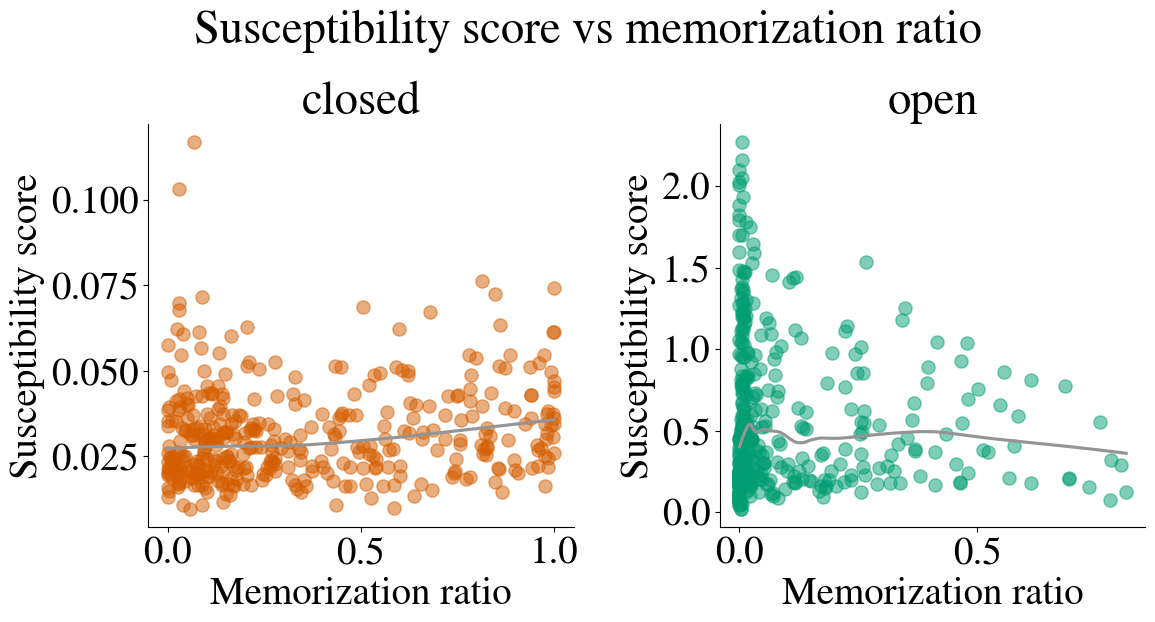

In [26]:
# matplotlib.rcParams["font.size"] = "30"
colormap = {"closed": CLOSED_COLOR, "open": OPEN_COLOR}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
scatter_kws = {"s": 90, "alpha": 0.5}

qid_to_dfs_with_mr = dict(
    sorted(
        {
            qid: df
            for qid, df in qid_to_val_df_per_qe.items()
            if "sampled_mr" in df.columns
        }.items()
    )
)
qid_df_mr_all = pd.concat(list(qid_to_dfs_with_mr.values()), axis=0)
qid_df_mr_all_grouped = (
    qid_df_mr_all.groupby(["q_id", "query_form", "query_type", "type"])
    .agg({"susceptibility_score": "mean", "sampled_mr": "mean"})
    .reset_index()
)

for i, qt in enumerate(reversed(qid_df_mr_all_grouped["query_type"].unique())):
    ax = axes[i]
    sns.regplot(
        data=qid_df_mr_all_grouped[qid_df_mr_all_grouped["query_type"] == qt],
        x="sampled_mr",
        y="susceptibility_score",
        # hue="query_type",
        # legend=None,
        lowess=True,
        ax=ax,
        line_kws={"color": LINE_COLOR},
        scatter_kws={**scatter_kws, "color": colormap[qt]},
    )
    ax.set_title(qt)
    ax.set_xlabel("Memorization ratio")
    ax.set_ylabel("Susceptibility score")

fig.suptitle("Susceptibility score vs memorization ratio", y=0.92)
plt.tight_layout()
plot_name = "plot_susscore_vs_mr_open_closed_all_queries"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")
wandb.log({plot_name: wandb.Image(fig)})

### Comparison to MR - persuasion

In [27]:
val_df_per_qe = next(iter(qid_to_val_df_per_qe.items()))[1]

In [28]:
def explode_val_df_per_qe(val_df_per_qe):
    if isinstance(val_df_per_qe["sampled_answergroups"].iloc[0], str):
        val_df_per_qe["sampled_answergroups"] = val_df_per_qe[
            "sampled_answergroups"
        ].apply(literal_eval)

    val_df_per_qe["combined"] = val_df_per_qe.apply(
        lambda row: list(
            zip(
                row["contexts"],
                row["persuasion_scores_kl"],
                row["sampled_answergroups"],
            )
        ),
        axis=1,
    )
    exploded_df = pd.DataFrame(val_df_per_qe.explode("combined"))
    exploded_df[["context", "p_score", "sampled_answergroup"]] = pd.DataFrame(
        exploded_df["combined"].tolist(), index=exploded_df.index
    )
    exploded_df.drop(columns=["combined"], inplace=True)
    val_df_per_qe.drop(columns=["combined"], inplace=True)

    return exploded_df

In [29]:
set(qid_to_val_df_per_qe).difference(set(qid_to_dfs_with_mr))

{'http://schema.org/duration',
 'http://schema.org/humanDevelopmentIndex',
 'http://schema.org/lyricist',
 'http://schema.org/manufacturer',
 'http://schema.org/musicBy',
 'http://schema.org/neighbors',
 'http://schema.org/numberOfEmployees',
 'http://schema.org/numberOfEpisodes',
 'http://schema.org/numberOfPages',
 'http://schema.org/numberOfSeasons',
 'http://schema.org/populationNumber',
 'http://yago-knowledge.org/resource/sportNumber',
 'http://yago-knowledge.org/resource/studentsCount'}

In [30]:
for qid, df in qid_to_dfs_with_mr.items():
    if isinstance(df["sampled_answergroups"].iloc[0], str):
        print(qid)
        df["sampled_answergroups"] = df["sampled_answergroups"].apply(literal_eval)
        qid_to_dfs_with_mr[qid] = df

In [31]:
# # Closed queries - plot persuasion scores vs sampled answer group for all queries
# qid_to_dfs_with_mr = dict(
#     sorted(
#         {
#             qid: df
#             for qid, df in qid_to_val_df_per_qe.items()
#             if "sampled_mr" in df.columns
#         }.items()
#     )
# )
# num_qids = len(qid_to_dfs_with_mr)
# ncols = 4
# nrows = math.ceil(num_qids / ncols)
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 7, nrows * 7))
# for i, (qid, df) in tqdm(enumerate(qid_to_dfs_with_mr.items())):
#     row, col = i // ncols, i % ncols
#     qt_df = df[df["query_type"] == "closed"]
#     exploded_df = explode_val_df_per_qe(qt_df)
#     ax = axes[row, col]
#     sns.violinplot(exploded_df, x="sampled_answergroup", y="p_score", ax=ax)
#     ax.set_title(qid)
#     # x = df["susceptibility_score"]
#     # x = sm.add_constant(x)
#     # y = df["sampled_mr"]
#     # ols_model = sm.OLS(y, x).fit()
#     # ols_model.summary()
# plt.tight_layout()
# plot_name = "plot_pscore_vs_answergroup_closed_all"
# save_path = os.path.join(analysis_dir, f"{plot_name}.png")
# fig.savefig(save_path)
# wandb.log({plot_name: wandb.Image(fig)})

In [26]:
exploded_df_all = explode_val_df_per_qe(
    pd.concat(list(qid_to_dfs_with_mr.values()), axis=0)
)

: 

In [67]:
mean_pscore_per_answergroup = (
    exploded_df_all.groupby(["q_id", "query_form", "query_type", "sampled_answergroup"])
    .agg({"p_score": "mean"})
    .reset_index()
)

In [68]:
from measuring.estimate_probs import AnswerGroup

In [69]:
answergroup_to_presentable = {
    AnswerGroup.ORIGINAL.value: "Original",
    AnswerGroup.CONTEXT.value: "Context",
    AnswerGroup.OTHER.value: "Other",
}
mean_pscore_per_answergroup["presentable_answergroup"] = mean_pscore_per_answergroup[
    "sampled_answergroup"
].apply(lambda x: answergroup_to_presentable[x])

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


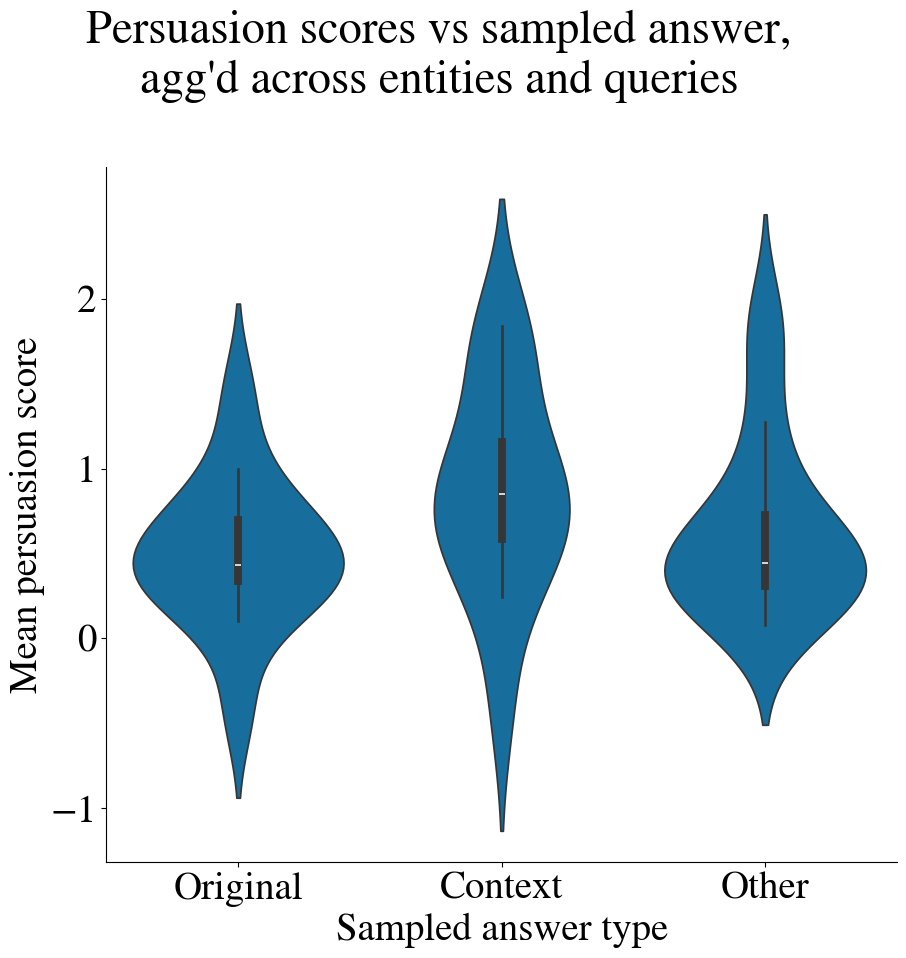

In [70]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.violinplot(
    data=mean_pscore_per_answergroup[
        (mean_pscore_per_answergroup["query_type"] == "open")
    ],
    x="presentable_answergroup",
    y="p_score",
    ax=ax,
)
ax.set_xlabel("Sampled answer type")
ax.set_ylabel("Mean persuasion score")
fig.suptitle("Persuasion scores vs sampled answer,\nagg'd across entities and queries")
plt.tight_layout()
plot_name = f"plot_pscore_vs_sampled_answer_agg_ents_and_queries_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


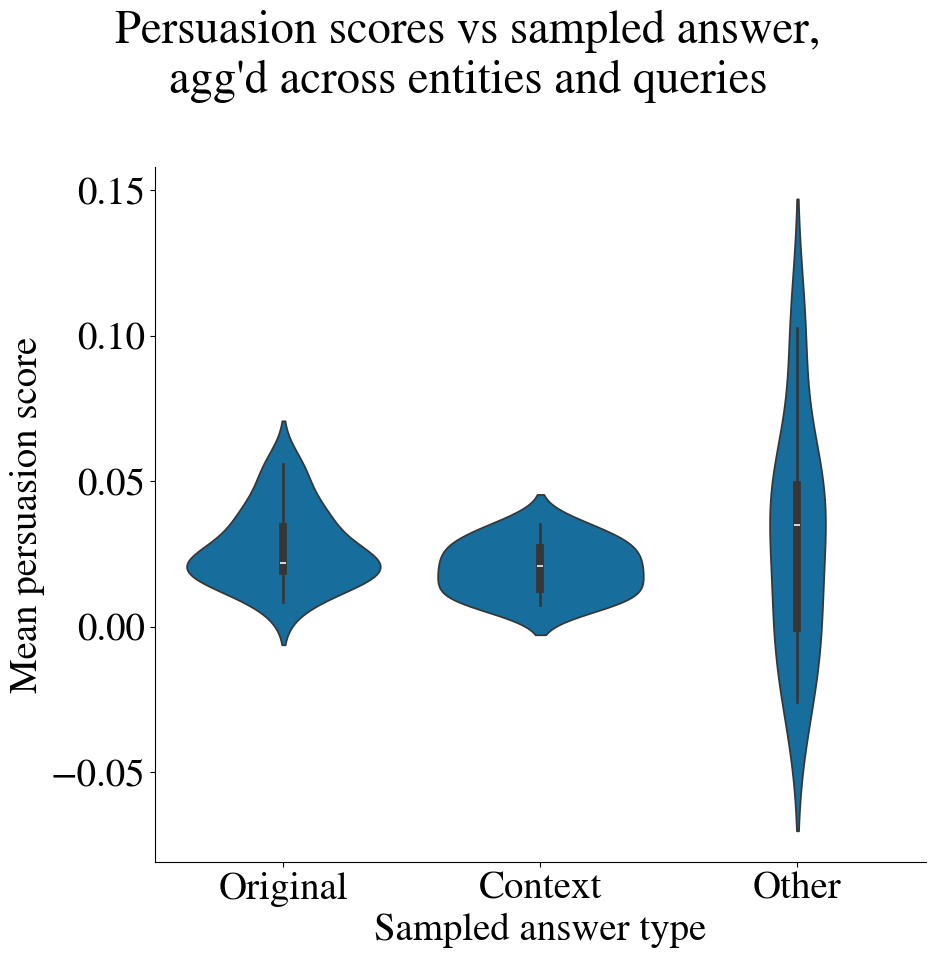

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.violinplot(
    data=mean_pscore_per_answergroup[
        (mean_pscore_per_answergroup["query_type"] == "closed")
    ],
    x="presentable_answergroup",
    y="p_score",
    ax=ax,
)
ax.set_xlabel("Sampled answer type")
ax.set_ylabel("Mean persuasion score")
fig.suptitle("Persuasion scores vs sampled answer,\nagg'd across entities and queries")
plt.tight_layout()
plot_name = f"plot_pscore_vs_sampled_answer_agg_ents_and_queries_closed"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

In [72]:
mean_pscore_per_answergroup

,q_id,query_form,query_type,sampled_answergroup,p_score,presentable_answergroup
0,http://schema.org/children,Q: Is {answer} a child of {entity}?\nA:,closed,0,0.055977,Original
1,http://schema.org/children,Q: Is {answer} a child of {entity}?\nA:,closed,1,0.029736,Context
2,http://schema.org/children,Q: Is {answer} a child of {entity}?\nA:,closed,2,0.038473,Other
3,http://schema.org/children,Q: Is {entity} a parent of {answer}?\nA:,closed,0,0.050472,Original
4,http://schema.org/children,Q: Is {entity} a parent of {answer}?\nA:,closed,1,0.029313,Context
...,...,...,...,...,...,...
90,reverse-http://yago-knowledge.org/resource/con...,Q: Was the '{answer}' conferred by {entity}?\nA:,closed,0,0.024280,Original
91,reverse-http://yago-knowledge.org/resource/con...,Q: Was the '{answer}' conferred by {entity}?\nA:,closed,1,0.020686,Context
92,reverse-http://yago-knowledge.org/resource/con...,Q: Was the '{answer}' conferred by {entity}?\nA:,closed,2,-0.000664,Other
93,reverse-http://yago-knowledge.org/resource/con...,Q: What was conferred upon '{entity}'?\nA:,open,0,-0.407205,Original


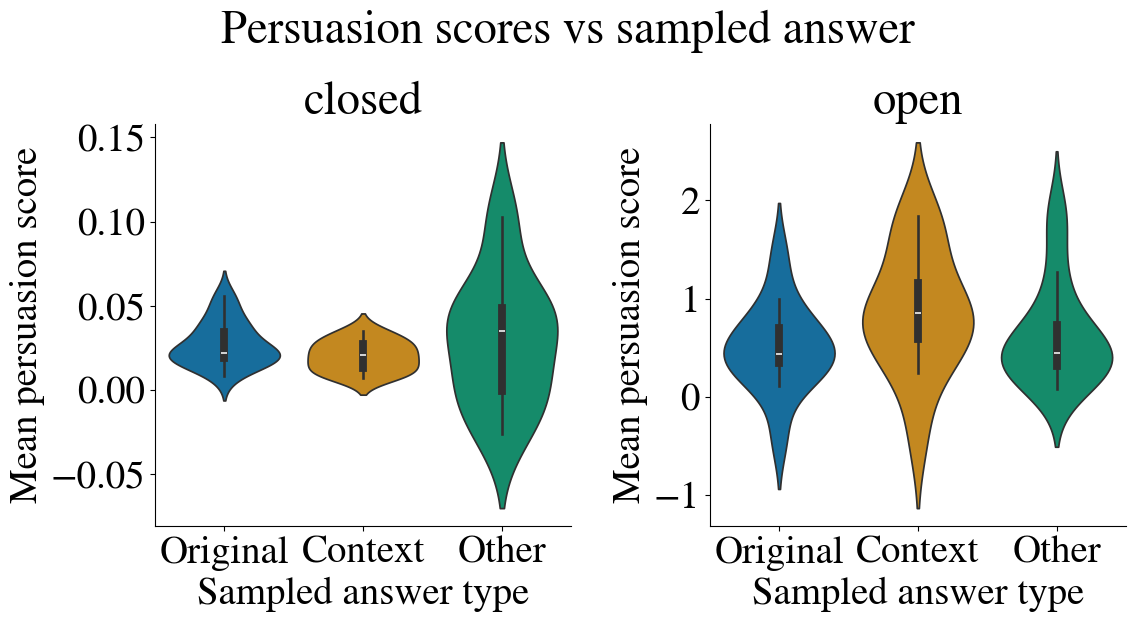

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
for i, qt in enumerate(mean_pscore_per_answergroup["query_type"].unique()):
    ax = axes[i]
    sns.violinplot(
        data=mean_pscore_per_answergroup[
            mean_pscore_per_answergroup["query_type"] == qt
        ],
        x="presentable_answergroup",
        y="p_score",
        hue="presentable_answergroup",
        # size=10,
        # dodge=True,
        ax=ax,
    )
    ax.set_title(qt)
    ax.set_xlabel("Sampled answer type")
    ax.set_ylabel("Mean persuasion score")
fig.suptitle(
    "Persuasion scores vs sampled answer",
    y=0.92,
)
plt.tight_layout()
plot_name = f"plot_pscore_vs_sampled_answer_agg_ents_and_queries_both"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

### Susceptibility Score vs Relation-dependent Entity Degree

In [74]:
QID_TO_ENTITY_DEG_PATH = "data/YagoECQ/entity_uri_to_predicate_degree_path.json"
with open(QID_TO_ENTITY_DEG_PATH) as f:
    qid_to_entity_degree = json.load(f)

len(qid_to_entity_degree)

127

In [75]:
qid_ent_deg_df = pd.DataFrame(
    [
        (qid, entity_uri, degree)
        for qid, entity_to_degree in qid_to_entity_degree.items()
        for entity_uri, degree in entity_to_degree.items()
    ],
    columns=["q_id", "entity_uri", "qid_ent_degree"],
)

In [76]:
def convert_entity_uri_to_entity(row: pd.Series):
    try:
        q_id = row["q_id"]
        entity_uris = yago_qec[q_id]["entity_uris"]
        eu_index = entity_uris.index(row["entity_uri"])
        entities = yago_qec[q_id]["entities"]

        return entities[eu_index]
    except (KeyError, ValueError):
        return None

In [77]:
qid_ent_deg_df["entity"] = qid_ent_deg_df.apply(convert_entity_uri_to_entity, axis=1)
qid_ent_deg_df = qid_ent_deg_df.dropna()
qid_ent_deg_df["entity"] = qid_ent_deg_df["entity"].apply(lambda x: (x,))
qid_ent_deg_df["qid_ent_degree"] = pd.to_numeric(qid_ent_deg_df["qid_ent_degree"])

In [78]:
val_dfs_all = pd.concat(list(qid_to_val_df_per_qe.values()), axis=0)

In [79]:
val_dfs_with_deg = val_dfs_all.merge(qid_ent_deg_df, on=["q_id", "entity"])
val_dfs_with_deg["log_qid_ent_degree"] = val_dfs_with_deg["qid_ent_degree"].apply(
    np.log
)
val_dfs_with_deg

,q_id,query_form,entity,answer,contexts,persuasion_scores,type,susceptibility_score,entity_classes,query_type,...,mean_relevant_p_score,mean_irrelevant_p_score,relevant_p_scores,irrelevant_p_scores,sampled_mr,sampled_answergroups,sampled_outputs,entity_uri,qid_ent_degree,log_qid_ent_degree
0,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Crime and Punishment,)",anguish,['A Canticle for the Sage' is about World War ...,"[0.22650313, 0.08221483, 0.3177483, 0.09433079...",entities,0.041684,{'http://schema.org/CreativeWork': 0.586206896...,closed,...,0.284032,0.039236,"[-0.03015232, 0.51616526, 0.32481432, 0.306092...","[0.22650313, 0.08221483, 0.3177483, 0.09433079...",NaN,NaN,NaN,http://yago-knowledge.org/resource/Crime_and_P...,2,0.693147
1,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Stranger Things,)",monster,['A Canticle for the Sage' is about World War ...,"[0.14263058, -0.065936565, 0.14722514, 0.09540...",entities,0.035881,{'http://schema.org/CreativeWork': 0.586206896...,closed,...,0.224726,0.033974,"[0.047500372, 0.26572442, 0.08702588, 0.405298...","[0.14263058, -0.065936565, 0.14722514, 0.09540...",NaN,NaN,NaN,http://yago-knowledge.org/resource/Stranger_Th...,3,1.098612
2,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Sleeping Beauty,)",prostitution,['A Canticle for the Sage' is about World War ...,"[0.23790836, 0.12632012, 0.11355591, 0.1759378...",entities,0.029870,{'http://schema.org/CreativeWork': 0.586206896...,closed,...,0.163050,0.028525,"[0.16081715, 0.23109388, 0.24823546, 0.0785043...","[0.23790836, 0.12632012, 0.11355591, 0.1759378...",NaN,NaN,NaN,http://yago-knowledge.org/resource/Sleeping_Be...,1,0.000000
3,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Sleeping Beauty,)",prostitution,['A Canticle for the Sage' is about World War ...,"[0.23790836, 0.12632012, 0.11355591, 0.1759378...",entities,0.029870,{'http://schema.org/CreativeWork': 0.586206896...,closed,...,0.163050,0.028525,"[0.16081715, 0.23109388, 0.24823546, 0.0785043...","[0.23790836, 0.12632012, 0.11355591, 0.1759378...",NaN,NaN,NaN,http://yago-knowledge.org/resource/Sleeping_Be...,4,1.386294
4,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,(Indiana Jones and the Kingdom of the Crystal ...,Cold War,['A Canticle for the Sage' is about World War ...,"[0.16338634, 0.12703824, 0.24769211, 0.0472652...",entities,0.030935,{'http://schema.org/CreativeWork': 0.586206896...,closed,...,0.187598,0.029353,"[0.37579584, 0.3231306, 0.24080443, -0.0979428...","[0.16338634, 0.12703824, 0.24769211, 0.0472652...",NaN,NaN,NaN,http://yago-knowledge.org/resource/Indiana_Jon...,2,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23799,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,"(Kansas,)",Missouri Route 92,[Aetherstone is the terminus of California Sta...,"[1.3338625, 1.1501553, 1.2017746, -0.4808774, ...",entities,1.242247,{'http://schema.org/Organization': 0.404761904...,open,...,1.288178,1.241783,"[2.3960764, 0.5793052, 1.3439794, 1.1071675, 1...","[1.3338625, 1.1501553, 1.2017746, -0.4808774, ...",NaN,NaN,NaN,http://yago-knowledge.org/resource/Kansas,19,2.944439
23800,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,"(West Virginia,)",Maryland Route 36,[Aetherstone is the terminus of California Sta...,"[0.9659231, 1.4668739, 1.3173232, -0.017874718...",entities,1.183810,{'http://schema.org/Organization': 0.404761904...,open,...,0.551934,1.190193,"[0.5091455, 1.5777512, 0.18174028, -0.10105991...","[0.9659231, 1.4668739, 1.3173232, -0.017874718...",NaN,NaN,NaN,http://yago-knowledge.org/resource/West_Virginia,3,1.098612
23801,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,"(Geneva,)",European route E21,[Aetherstone is the terminus of California Sta...,"[2.735675, 1.7640126, 1.3660069, -1.1217537, 2...",entities,1.944474,{'http://schema.org/Organi

In [80]:
from scipy import stats as sst

sst.spearmanr(
    val_dfs_with_deg[val_dfs_with_deg["query_type"] == "open"][
        ["log_qid_ent_degree", "susceptibility_score"]
    ]
)

SignificanceResult(statistic=0.11432898726004843, pvalue=6.370135648320744e-36)

In [81]:
val_dfs_with_deg[val_dfs_with_deg["query_type"] == "open"][
    ["log_qid_ent_degree", "susceptibility_score"]
].to_csv(
    os.path.join(analysis_dir, "log_qid_ent_deg_vs_sus_score_open.csv"), index=False
)

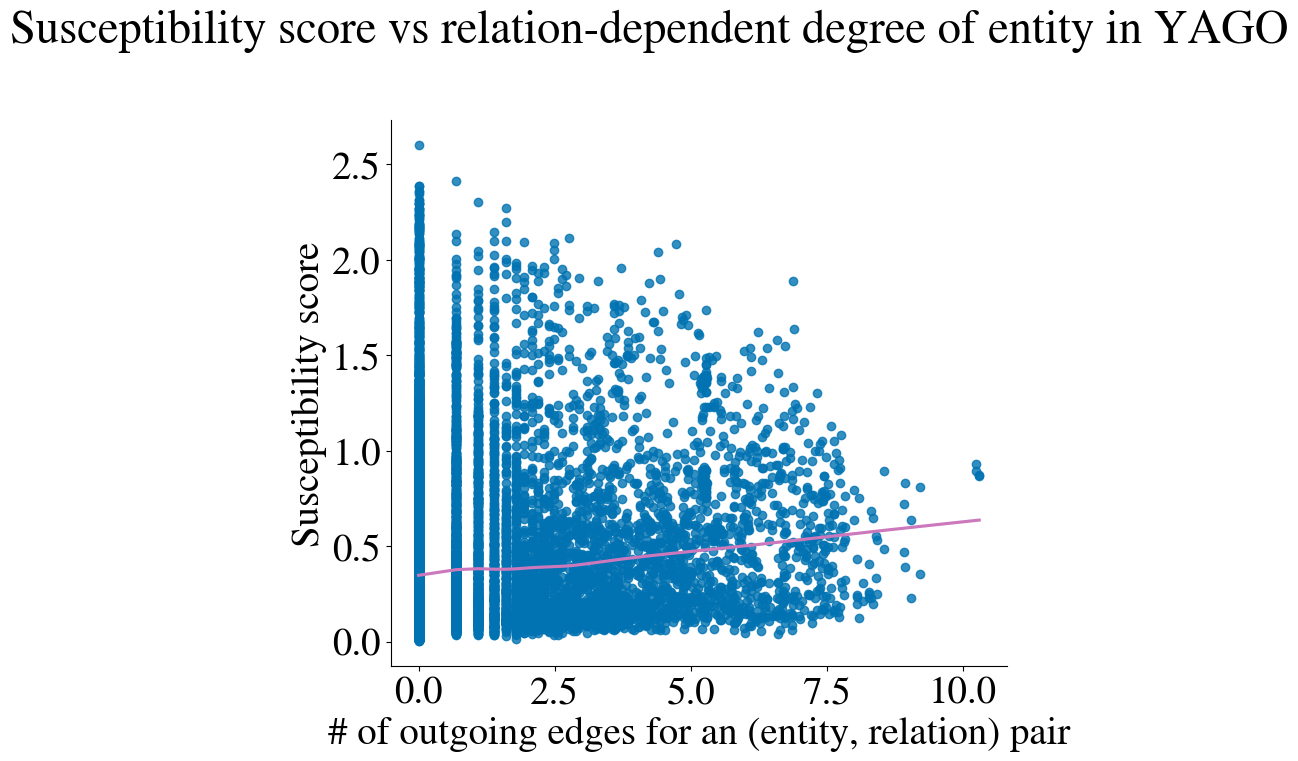

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
sns.regplot(
    data=val_dfs_with_deg[val_dfs_with_deg["query_type"] == "open"],
    x="log_qid_ent_degree",
    y="susceptibility_score",
    # hue="query_type",
    lowess=True,
    line_kws={"color": palette[4]},
    ax=ax,
)
ax.set_xlabel("# of outgoing edges for an (entity, relation) pair")
ax.set_ylabel("Susceptibility score")
fig.suptitle("Susceptibility score vs relation-dependent degree of entity in YAGO")
plt.tight_layout()
ax.set_ylim
plot_name = f"plot_susscore_vs_yago_qid_degree_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

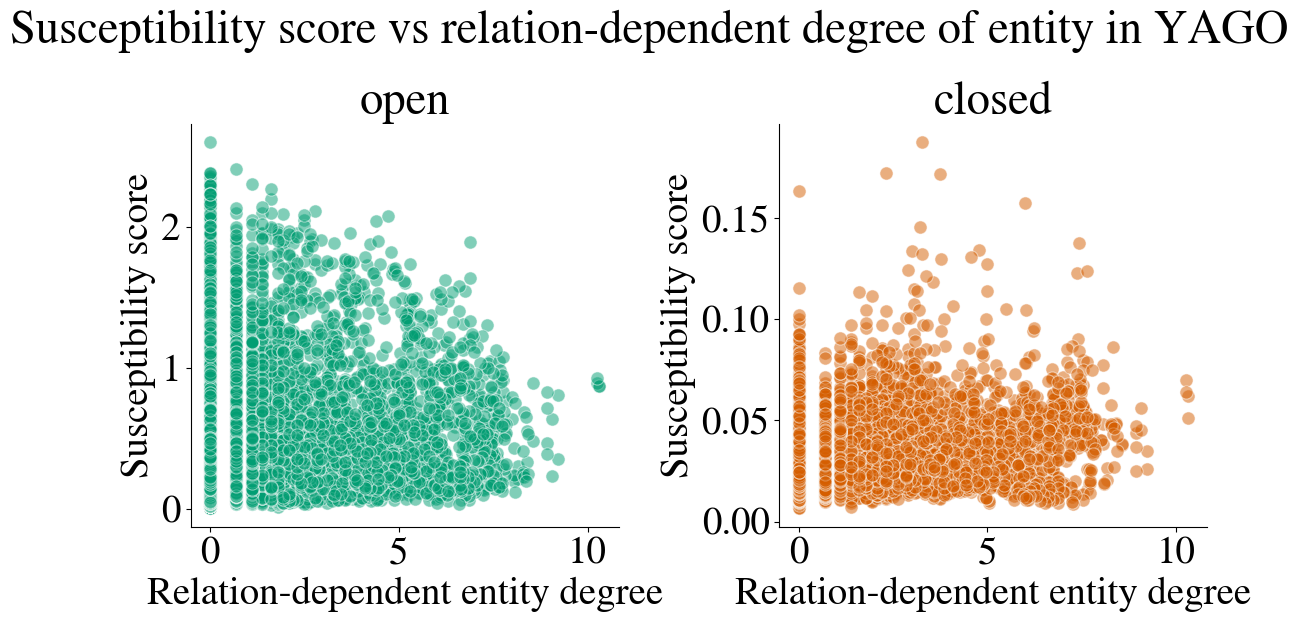

In [83]:
# matplotlib.rcParams["font.size"] = "30"
colormap = {"closed": CLOSED_COLOR, "open": OPEN_COLOR}
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
scatter_kws = {"s": 90, "alpha": 0.5}

for i, qt in enumerate(reversed(val_dfs_with_deg["query_type"].unique())):
    ax = axes[i]
    sns.scatterplot(
        data=val_dfs_with_deg[val_dfs_with_deg["query_type"] == qt],
        x="log_qid_ent_degree",
        y="susceptibility_score",
        # hue="query_type",
        # size=10,
        # dodge=True,
        ax=ax,
        color=colormap[qt],
        legend=None,
        **scatter_kws,
    )
    ax.set_title(qt)
    ax.set_xlabel("Relation-dependent entity degree")
    ax.set_ylabel("Susceptibility score")
fig.suptitle(
    "Susceptibility score vs relation-dependent degree of entity in YAGO",
    y=0.92,
)
plt.tight_layout()
plot_name = f"plot_susscore_vs_yago_qid_degree_both"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")
# matplotlib.rcParams["font.size"] = "28"

### Susceptibility Score vs Entity Degree

In [84]:
### Entity degree (Query independent) ###
ENTITY_DEG_PATH = "data/YagoECQ/entity_uri_to_degree.json"
with open(ENTITY_DEG_PATH) as f:
    entity_degree = json.load(f)

len(entity_degree)

96272

In [85]:
ent_degree_df = pd.DataFrame(
    [(ent_uri, deg) for ent_uri, deg in entity_degree.items()],
    columns=["entity_uri", "degree"],
)
ent_degree_df

,entity_uri,degree
0,http://yago-knowledge.org/resource/Paul_McCartney,894
1,http://yago-knowledge.org/resource/Paul_Allen_...,34
2,http://yago-knowledge.org/resource/Bicaz,90
3,http://yago-knowledge.org/resource/1992_Chines...,16
4,http://yago-knowledge.org/resource/Jane_Arthur,27
...,...,...
96267,http://yago-knowledge.org/resource/Republic_of...,40
96268,http://yago-knowledge.org/resource/Banda_do_Mar,24
96269,http://yago-knowledge.org/resource/Society_for...,473
96270,http://yago-knowledge.org/resource/Interstate_...,19


In [86]:
ENTITY_NAME_TO_URI_PATH = "data/YagoECQ/entity_name_to_possible_entity_uris.json"

with open(ENTITY_NAME_TO_URI_PATH) as f:
    entity_name_to_uri = json.load(f)
e_uri_to_name = {
    e_uri: entity_name
    for entity_name, e_uris in entity_name_to_uri.items()
    for e_uri in e_uris
}
len(e_uri_to_name)

ENTITY_URI_TO_NAME_PATH = "data/YagoECQ/entity_uri_to_name.json"
with open(ENTITY_URI_TO_NAME_PATH, "w", encoding="utf-8") as fp:
    json.dump(e_uri_to_name, fp, ensure_ascii=False, indent=4)

In [87]:
def convert_entity_uri_to_entity2(row: pd.Series):
    try:
        return e_uri_to_name[row["entity_uri"]]
    except (KeyError, ValueError):
        return None

In [88]:
ent_degree_df["entity"] = ent_degree_df.apply(convert_entity_uri_to_entity2, axis=1)
ent_degree_df = ent_degree_df.dropna()
ent_degree_df["entity"] = ent_degree_df["entity"].apply(lambda x: (x,))
ent_degree_df["degree"] = pd.to_numeric(ent_degree_df["degree"])
ent_degree_df

/scratch/tmp.50791700.kevidu/ipykernel_145671/2163315234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ent_degree_df["entity"] = ent_degree_df["entity"].apply(lambda x: (x,))
/scratch/tmp.50791700.kevidu/ipykernel_145671/2163315234.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ent_degree_df["degree"] = pd.to_numeric(ent_degree_df["degree"])


,entity_uri,degree,entity
0,http://yago-knowledge.org/resource/Paul_McCartney,894,"(Paul McCartney,)"
1,http://yago-knowledge.org/resource/Paul_Allen_...,34,"(Paul Allen,)"
2,http://yago-knowledge.org/resource/Bicaz,90,"(Bicaz,)"
3,http://yago-knowledge.org/resource/1992_Chines...,16,"(Chinese Jia-A League 1992,)"
4,http://yago-knowledge.org/resource/Jane_Arthur,27,"(Jane Arthur,)"
...,...,...,...
96267,http://yago-knowledge.org/resource/Republic_of...,40,"(Republic of Tarnobrzeg,)"
96268,http://yago-knowledge.org/resource/Banda_do_Mar,24,"(Banda do Mar,)"
96269,http://yago-knowledge.org/resource/Society_for...,473,"(Society for Industrial and Applied Mathematics,)"
96270,http://yago-knowledge.org/resource/Interstate_...,19,"(Interstate 80 Business,)"


In [89]:
val_dfs_with_ent_deg = val_dfs_all.merge(ent_degree_df, on=["entity"])
val_dfs_with_ent_deg["log_degree"] = val_dfs_with_ent_deg["degree"].apply(np.log)
val_dfs_with_ent_deg

,q_id,query_form,entity,answer,contexts,persuasion_scores,type,susceptibility_score,entity_classes,query_type,...,mean_relevant_p_score,mean_irrelevant_p_score,relevant_p_scores,irrelevant_p_scores,sampled_mr,sampled_answergroups,sampled_outputs,entity_uri,degree,log_degree
0,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Crime and Punishment,)",anguish,['A Canticle for the Sage' is about World War ...,"[0.22650313, 0.08221483, 0.3177483, 0.09433079...",entities,0.041684,{'http://schema.org/CreativeWork': 0.586206896...,closed,...,0.284032,0.039236,"[-0.03015232, 0.51616526, 0.32481432, 0.306092...","[0.22650313, 0.08221483, 0.3177483, 0.09433079...",NaN,NaN,NaN,http://yago-knowledge.org/resource/Crime_and_P...,89,4.488636
1,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Crime and Punishment,)",anguish,['A Canticle for the Sage' is about World War ...,"[0.22650313, 0.08221483, 0.3177483, 0.09433079...",entities,0.041684,{'http://schema.org/CreativeWork': 0.586206896...,closed,...,0.284032,0.039236,"[-0.03015232, 0.51616526, 0.32481432, 0.306092...","[0.22650313, 0.08221483, 0.3177483, 0.09433079...",NaN,NaN,NaN,http://yago-knowledge.org/resource/Crime_and_P...,294,5.683580
2,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Crime and Punishment,)",anguish,['A Canticle for the Sage' is about World War ...,"[0.22650313, 0.08221483, 0.3177483, 0.09433079...",entities,0.041684,{'http://schema.org/CreativeWork': 0.586206896...,closed,...,0.284032,0.039236,"[-0.03015232, 0.51616526, 0.32481432, 0.306092...","[0.22650313, 0.08221483, 0.3177483, 0.09433079...",NaN,NaN,NaN,http://yago-knowledge.org/resource/Crime_and_P...,57,4.043051
3,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Stranger Things,)",monster,['A Canticle for the Sage' is about World War ...,"[0.14263058, -0.065936565, 0.14722514, 0.09540...",entities,0.035881,{'http://schema.org/CreativeWork': 0.586206896...,closed,...,0.224726,0.033974,"[0.047500372, 0.26572442, 0.08702588, 0.405298...","[0.14263058, -0.065936565, 0.14722514, 0.09540...",NaN,NaN,NaN,http://yago-knowledge.org/resource/Stranger_Th...,264,5.575949
4,http://schema.org/about,Q: Is '{entity}' about {answer}?\nA:,"(Sleeping Beauty,)",prostitution,['A Canticle for the Sage' is about World War ...,"[0.23790836, 0.12632012, 0.11355591, 0.1759378...",entities,0.029870,{'http://schema.org/CreativeWork': 0.586206896...,closed,...,0.163050,0.028525,"[0.16081715, 0.23109388, 0.24823546, 0.0785043...","[0.23790836, 0.12632012, 0.11355591, 0.1759378...",NaN,NaN,NaN,http://yago-knowledge.org/resource/Sleeping_Be...,96,4.564348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25375,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,"(Geneva,)",European route E21,[Aetherstone is the terminus of California Sta...,"[2.735675, 1.7640126, 1.3660069, -1.1217537, 2...",entities,1.944474,{'http://schema.org/Organization': 0.404761904...,open,...,2.023368,1.943677,"[2.9089074, 2.8369496, 2.5485425, -0.07595968,...","[2.735675, 1.7640126, 1.3660069, -1.1217537, 2...",NaN,NaN,NaN,http://yago-knowledge.org/resource/Geneva_u002...,136,4.912655
25376,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,"(Geneva,)",European route E21,[Aetherstone is the terminus of California Sta...,"[2.735675, 1.7640126, 1.3660069, -1.1217537, 2...",entities,1.944474,{'http://schema.org/Organization': 0.404761904...,open,...,2.023368,1.943677,"[2.9089074, 2.8369496, 2.5485425, -0.07595968,...","[2.735675, 1.7640126, 1.3660069, -1.1217537, 2...",NaN,NaN,NaN,http://yago-knowledge.org/resource/Geneva_u002...,64,4.158883
25377,reverse-http://yago-knowledge.org/resource/ter...,{entity} is the terminus of,"(Edmonton,)",Alberta Highway 15,[Aetherstone is the terminus of California Sta...,"[1.9083769, 1.2177229, 1.9210463, -0.60576916,...",entities,1.452103,{'http://schema.org/Organization': 0.404761904...,op

In [90]:
from scipy import stats as sst

sst.spearmanr(
    val_dfs_with_ent_deg[val_dfs_with_ent_deg["query_type"] == "open"][
        ["log_degree", "susceptibility_score"]
    ]
)

SignificanceResult(statistic=-0.03808042013399221, pvalue=1.779590988738253e-05)

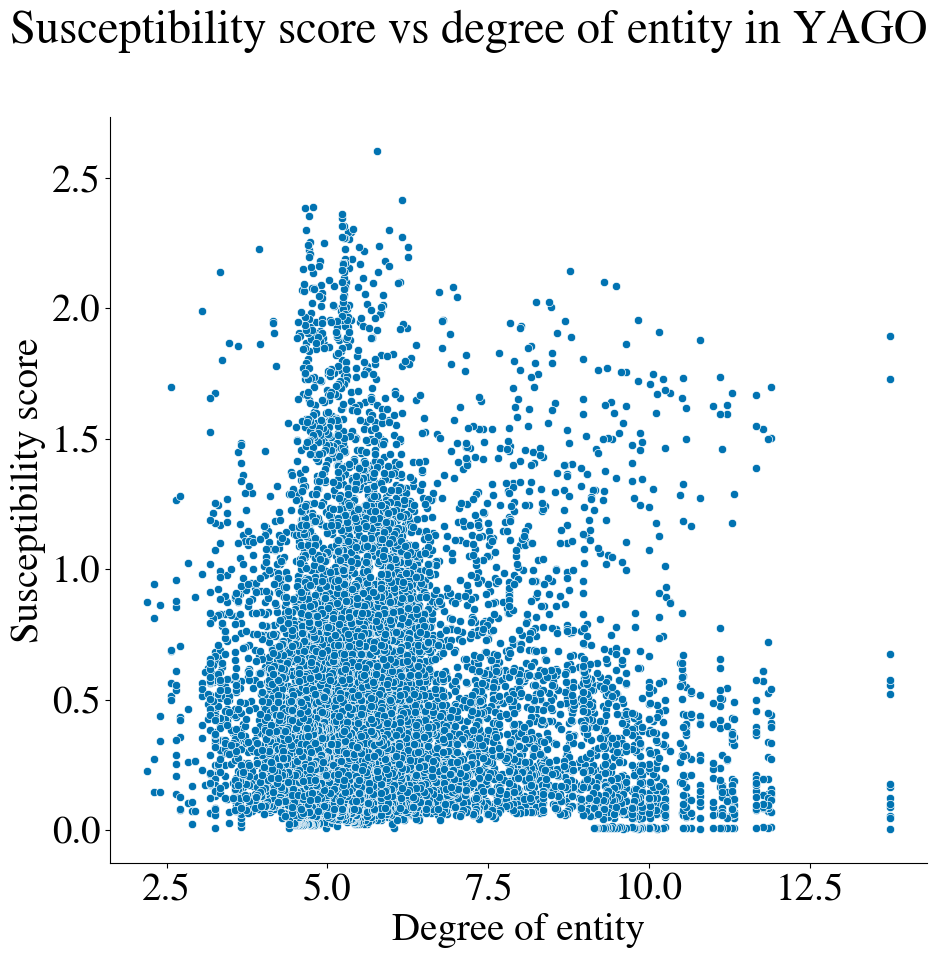

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sns.scatterplot(
    data=val_dfs_with_ent_deg[val_dfs_with_ent_deg["query_type"] == "open"],
    x="log_degree",
    y="susceptibility_score",
)
ax.set_xlabel("Degree of entity")
ax.set_ylabel("Susceptibility score")
fig.suptitle("Susceptibility score vs degree of entity in YAGO")
plt.tight_layout()
plot_name = f"plot_susscore_vs_yago_degree_open"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")